# 1 - Data Collection

In [127]:
import yfinance as yf

In [128]:
ticker = "BAC"
data = yf.download(ticker)

[*********************100%%**********************]  1 of 1 completed


In [129]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1973-02-21,4.625000,4.625000,4.625000,4.625000,1.581813,99200
1973-02-22,4.640625,4.640625,4.640625,4.640625,1.587157,47200
1973-02-23,4.625000,4.625000,4.625000,4.625000,1.581813,133600
1973-02-26,4.625000,4.625000,4.625000,4.625000,1.581813,24000
1973-02-27,4.625000,4.625000,4.625000,4.625000,1.581813,41600
...,...,...,...,...,...,...
2024-01-08,34.299999,34.299999,33.639999,34.160000,34.160000,40253900
2024-01-09,33.820000,33.840000,33.509998,33.630001,33.630001,39268800
2024-01-10,33.500000,33.630001,33.240002,33.599998,33.599998,34904000


In [130]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [131]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,1.283600e+04
mean,17.296656,18.143155,17.728797,17.933966,12.300080,3.871861e+07
std,15.233087,14.682512,14.404409,14.546213,11.513032,7.800350e+07
min,0.000000,0.875000,0.828125,0.828125,0.283230,0.000000e+00
25%,0.000000,5.000000,4.906250,4.937500,1.747475,4.307000e+05
50%,13.625000,13.750000,13.468750,13.610000,9.648801,6.328650e+06
75%,29.730000,30.100000,29.330000,29.662500,20.531751,4.765225e+07
max,55.040001,55.080002,54.820000,54.900002,46.799236,1.226791e+09


In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

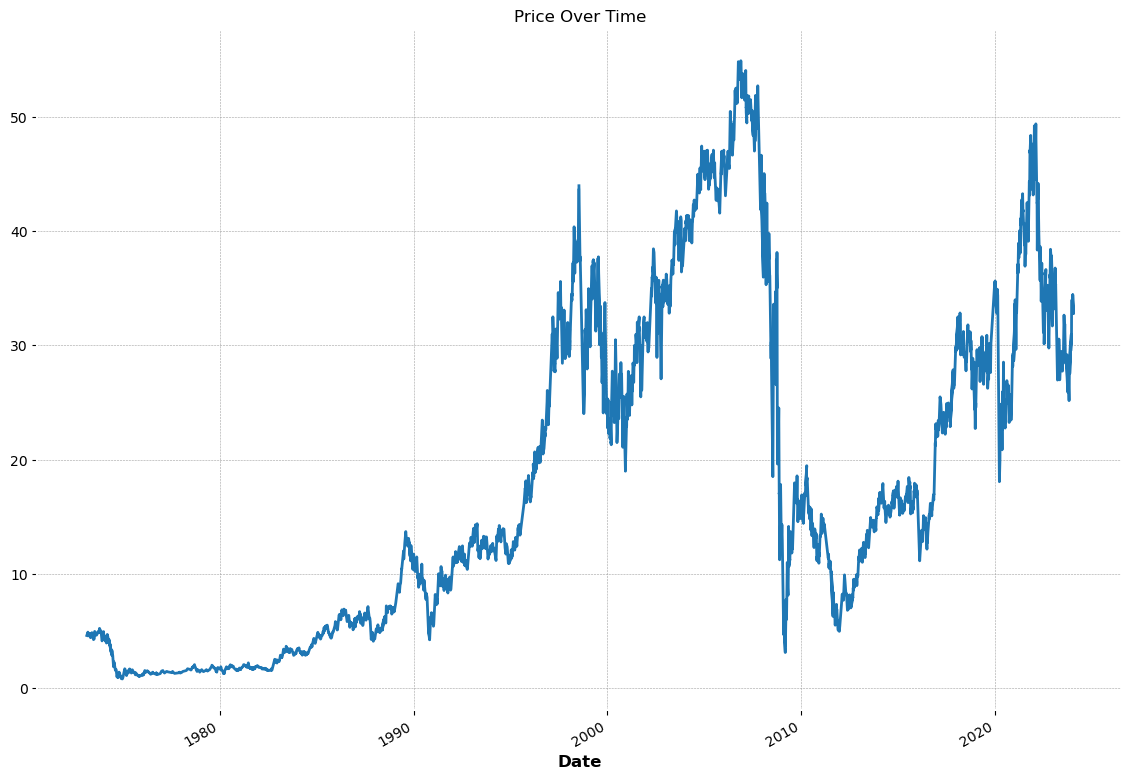

In [134]:
data['Close'].plot(figsize=(14, 10))
plt.title('Price Over Time')
plt.show()

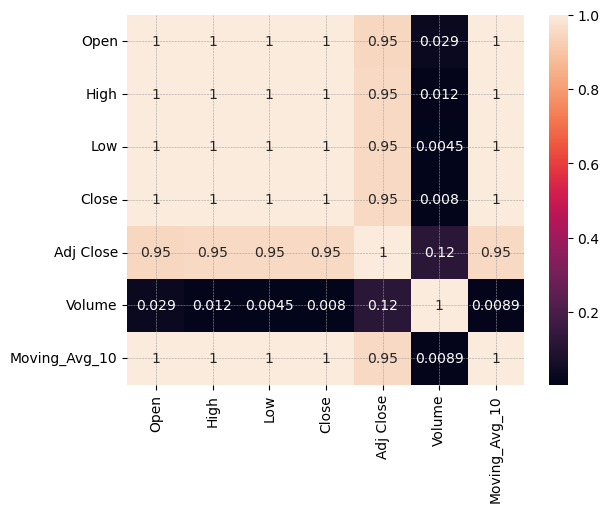

In [135]:
data['Moving_Avg_10'] = data['Close'].rolling(window=10).mean()

correlation = data.corr()
sns.heatmap(correlation, annot=True)
plt.show()

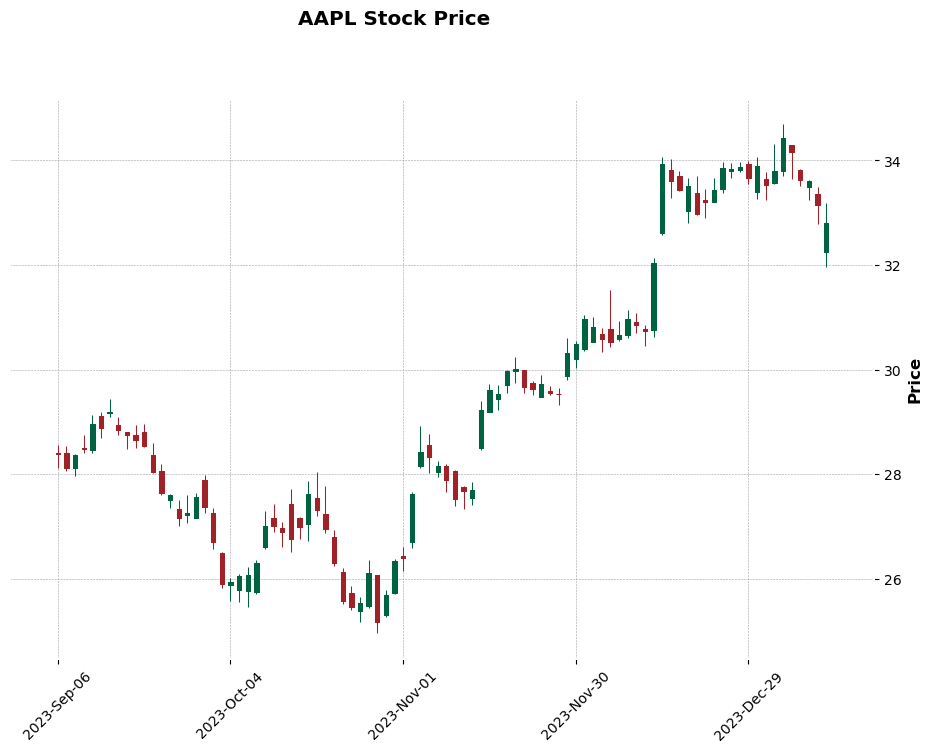

In [137]:
import mplfinance as mpf

mpf.plot(data.iloc[-90:], type='candle', style='charles', title='AAPL Stock Price', figsize=(12, 8))

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [186]:
train = data['Close'][:int(0.5*len(data))]
test = data['Close'][int(0.5*len(data)):]

In [205]:
def test_stationarity(timeseries):
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Tracé des statistiques mobiles
    pd.plotting.register_matplotlib_converters()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    plt.plot(rolling_std, color='black', label='Écart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et Écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    print("Résultats du Test de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Statistique de Test','p-value','#Lags Utilisés','Nombre d’Observations Utilisées'])
    for key,value in dftest[4].items():
        dfoutput['Valeur Critique (%s)'%key] = value
    print(dfoutput)

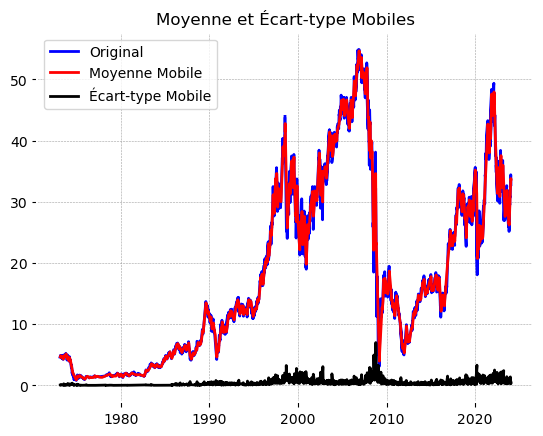

Résultats du Test de Dickey-Fuller:
Statistique de Test                   -1.512629
p-value                                0.527255
#Lags Utilisés                        38.000000
Nombre d’Observations Utilisées    12797.000000
Valeur Critique (1%)                  -3.430861
Valeur Critique (5%)                  -2.861766
Valeur Critique (10%)                 -2.566890
dtype: float64


In [206]:
test_stationarity(data['Close'])

In [208]:
log_serie = np.log(data)
log_diff_serie = log_serie.diff().dropna()

C:\Users\wailb\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [210]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Travailler avec la partie résiduelle
residual.dropna(inplace=True)

ValueError: This function does not handle missing values

In [196]:
model = ARIMA(train, order=(1,2,3)) 
model_fit = model.fit()

C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [197]:
predictions = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")

C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error: 20268.518681030313


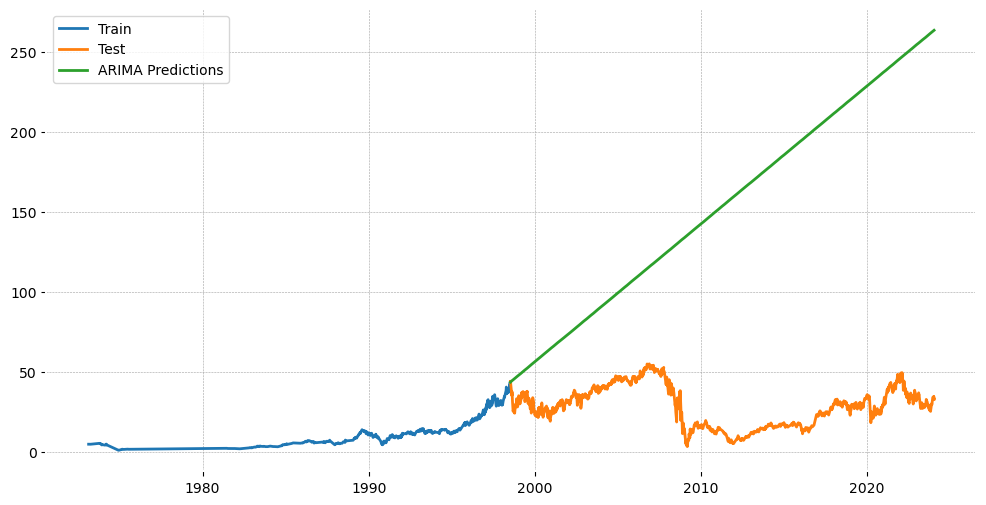

In [198]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='ARIMA Predictions')
plt.legend()
plt.show()

In [101]:
# data['Direction'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# data.dropna(inplace=True)

# X = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# y_direction = data['Direction']

# y_price = data['Close']

In [199]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

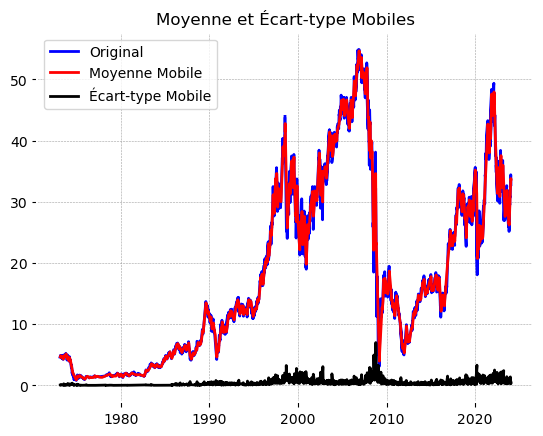

Résultats du Test de Dickey-Fuller:
Statistique de Test                   -1.512629
p-value                                0.527255
#Lags Utilisés                        38.000000
Nombre d’Observations Utilisées    12797.000000
Valeur Critique (1%)                  -3.430861
Valeur Critique (5%)                  -2.861766
Valeur Critique (10%)                 -2.566890
dtype: float64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Set the ticker
ticker = "BAC"

# Download hourly data for the last month
data = yf.download(ticker,start="2023-01-01", end="2024-01-01", interval='1h')

# Display the first few rows of the data
print(data.head())

# Check for missing values
print("Missing values in the dataset: \n", data.isnull().sum())

[*********************100%%**********************]  1 of 1 completed

                                Open       High        Low      Close  \
Datetime                                                                
2023-01-03 09:30:00-05:00  33.230000  33.849998  33.209999  33.519299   
2023-01-03 10:30:00-05:00  33.520000  34.090000  33.500000  33.770000   
2023-01-03 11:30:00-05:00  33.775002  33.810001  33.505001  33.525002   
2023-01-03 12:30:00-05:00  33.525002  33.619999  33.340000  33.415001   
2023-01-03 13:30:00-05:00  33.410000  33.459999  33.330002  33.345001   

                           Adj Close   Volume  
Datetime                                       
2023-01-03 09:30:00-05:00  33.519299  7317322  
2023-01-03 10:30:00-05:00  33.770000  5918666  
2023-01-03 11:30:00-05:00  33.525002  2973637  
2023-01-03 12:30:00-05:00  33.415001  2881572  
2023-01-03 13:30:00-05:00  33.345001  2186555  
Missing values in the dataset: 
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [29]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 1
X, Y = create_dataset(scaled_data, time_step)

In [30]:
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size

In [31]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(Y)]

In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [33]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
model.fit(X_train, y_train, batch_size=64, epochs=20)

Epoch 1/20
25/25 [==============================] - 7s 3ms/step - loss: 0.1202
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0348
Epoch 3/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 4/20
25/25 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 4.8198e-04
Epoch 6/20
25/25 [==============================] - 0s 3ms/step - loss: 4.0791e-04
Epoch 7/20
25/25 [==============================] - 0s 3ms/step - loss: 3.8358e-04
Epoch 8/20
25/25 [==============================] - 0s 3ms/step - loss: 3.7858e-04
Epoch 9/20
25/25 [==============================] - 0s 3ms/step - loss: 3.6934e-04
Epoch 10/20
25/25 [==============================] - 0s 3ms/step - loss: 3.6224e-04
Epoch 11/20
25/25 [==============================] - 0s 3ms/step - loss: 3.5486e-04
Epoch 12/20
25/25 [==============================] - 0s 3ms/step - loss: 3.4724e-04
Epoch 13/20
25/25

In [35]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)

6/6 [==============================] - 1s 2ms/step


In [61]:
len(X_test[:, 0][:,0])

174

6/6 [==============================] - 0s 1ms/step


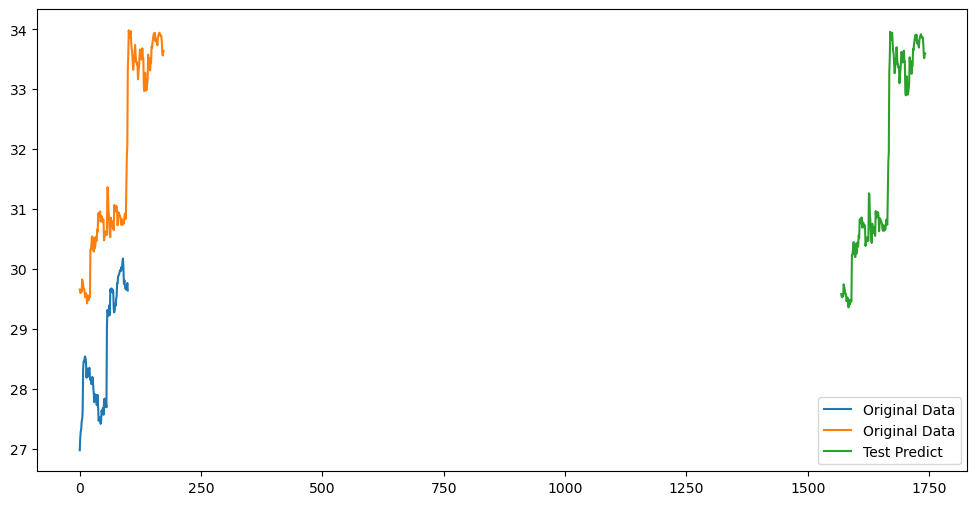

In [67]:
# Plotting the data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(X_train[:, 0]), label='Original Data')
plt.plot(scaler.inverse_transform(X_test[:, 0]), label='Original Data')
plt.plot(np.arange(len(train_predict) + (time_step*2) + 1, len(train_predict) + (time_step*2) + len(test_predict) + 1), test_predict, label='Test Predict')
plt.legend()
plt.show()

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [223]:
# Load data from Yahoo Finance for a specific stock (e.g., AAPL)
data = yf.download('AAPL', interval = "1d")

# Working with Closing Prices
close_prices = data['Close']

[*********************100%%**********************]  1 of 1 completed


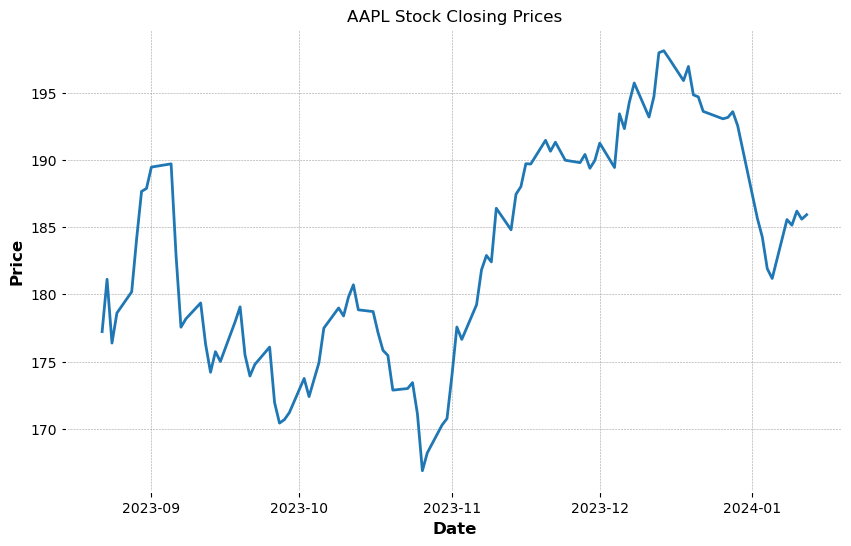

In [226]:
plt.figure(figsize=(10, 6))
plt.plot(close_prices[-100:])
plt.title('AAPL Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [217]:
def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

test_stationarity(close_prices)


ADF Statistic: 3.293007
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


ADF Statistic: -18.293433
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


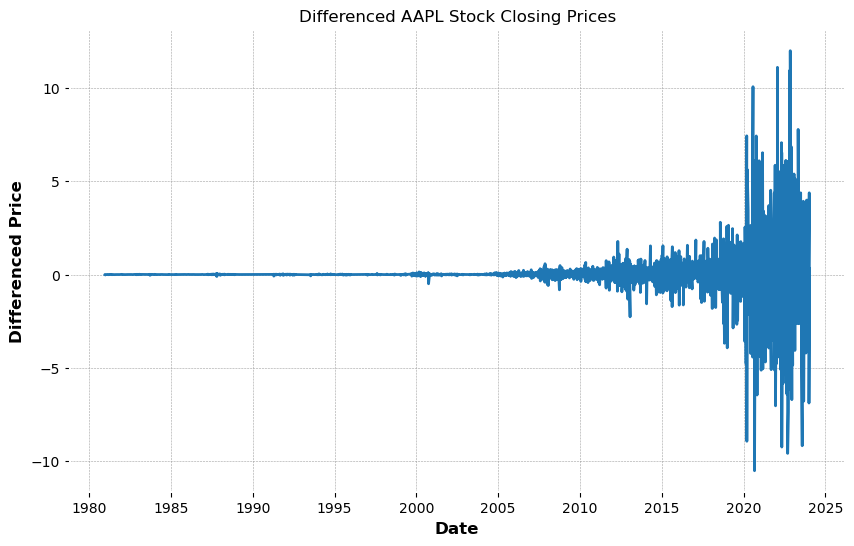

In [218]:
# Differencing
close_prices_diff = close_prices.diff().dropna()

# Test stationarity again
test_stationarity(close_prices_diff)

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(close_prices_diff)
plt.title('Differenced AAPL Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.show()


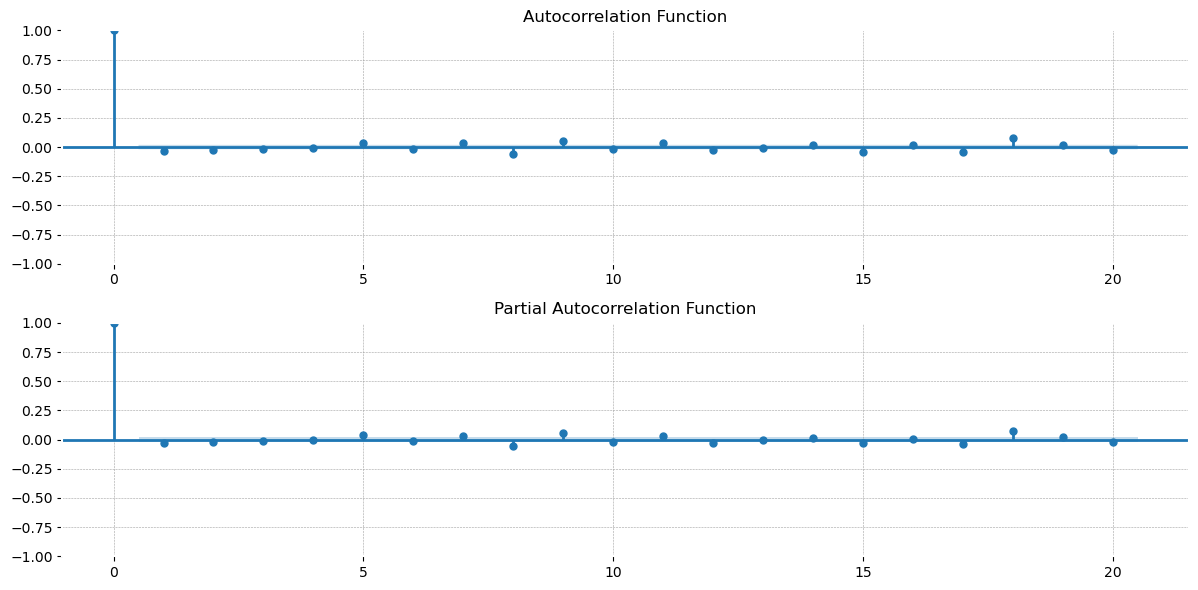

In [219]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(close_prices_diff, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(212)
plot_pacf(close_prices_diff, ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [262]:
train = close_prices['Close'][:int(0.9*len(close_prices))]
test = close_prices['Close'][int(0.9*len(close_prices)):]

KeyError: 'Close'

In [246]:
p = 10  # Example value
d = 1  # Differencing order
q = 3  # Example value

# Fit the ARIMA model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6418
Model:                ARIMA(10, 1, 3)   Log Likelihood                1602.802
Date:                Tue, 16 Jan 2024   AIC                          -3177.604
Time:                        00:51:29   BIC                          -3082.870
Sample:                             0   HQIC                         -3144.817
                               - 6418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4669      0.033    -14.215      0.000      -0.531      -0.402
ar.L2          0.4545      0.046      9.863      0.000       0.364       0.545
ar.L3          0.8981      0.029     30.653      0.0

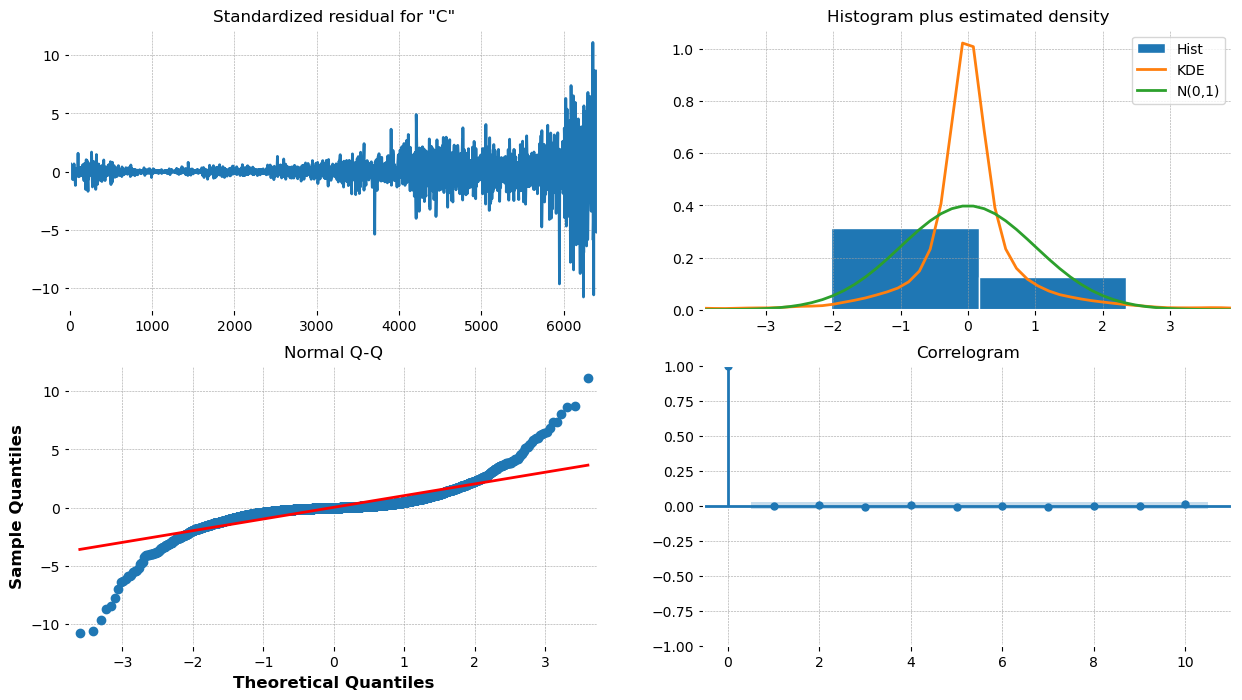

In [247]:
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

In [248]:
# Forecasting
forecast = model_fit.forecast(steps=30)  # Forecasting next 30 days

C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\wailb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


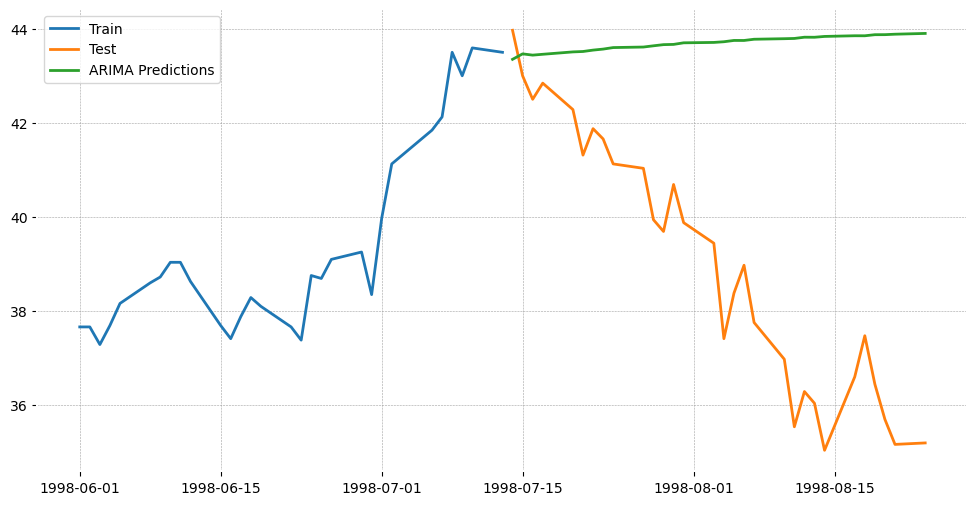

In [249]:
plt.figure(figsize=(12,6))
plt.plot(train[-30:].index, train[-30:], label='Train')
plt.plot(test[0:30].index, test[0:30], label='Test')
plt.plot(test[0:30].index, forecast, label='ARIMA Predictions')
plt.legend()
plt.show()

In [250]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [251]:
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
import itertools
pdq = list(itertools.product(p, d, q))

In [252]:
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages for cleaner output

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        # Create and fit ARIMA model
        model = SARIMAX(close_prices, order=param, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        
        # Compare with best AIC found so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

print(f"Best ARIMA Model: ARIMA{best_pdq} - AIC:{best_aic}")


Best ARIMA Model: ARIMA(2, 2, 2) - AIC:27074.093437457726


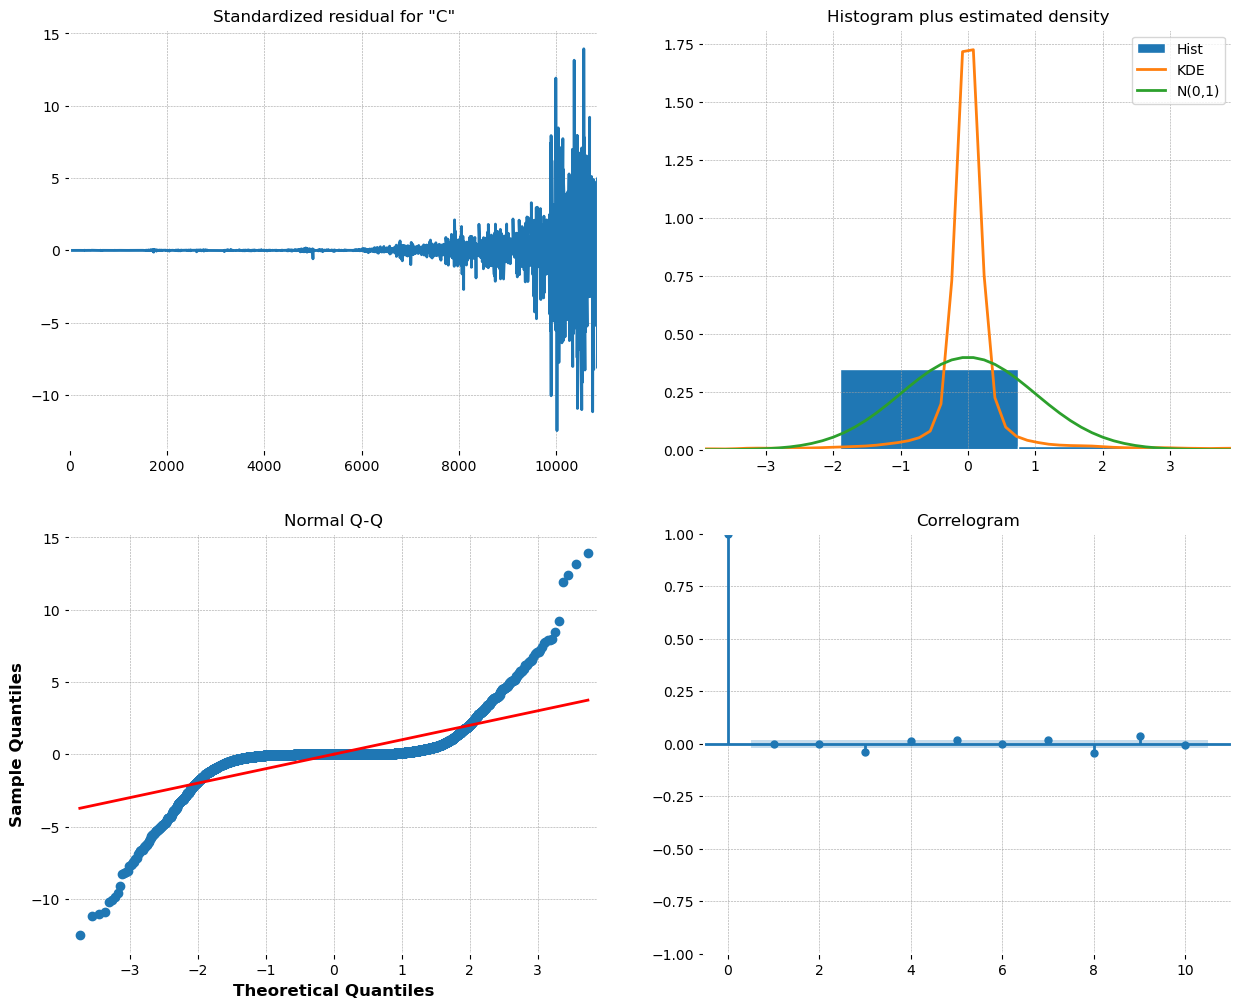

In [253]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                10862
Model:             SARIMAX(2, 2, 2)x(1, 1, [1], 12)   Log Likelihood              -13551.818
Date:                              Tue, 16 Jan 2024   AIC                          27117.635
Time:                                      01:14:51   BIC                          27168.668
Sample:                                           0   HQIC                         27134.841
                                            - 10862                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9350      0.010    -89.468      0.000      -0.955      -0.915
ar.L2         -0.05

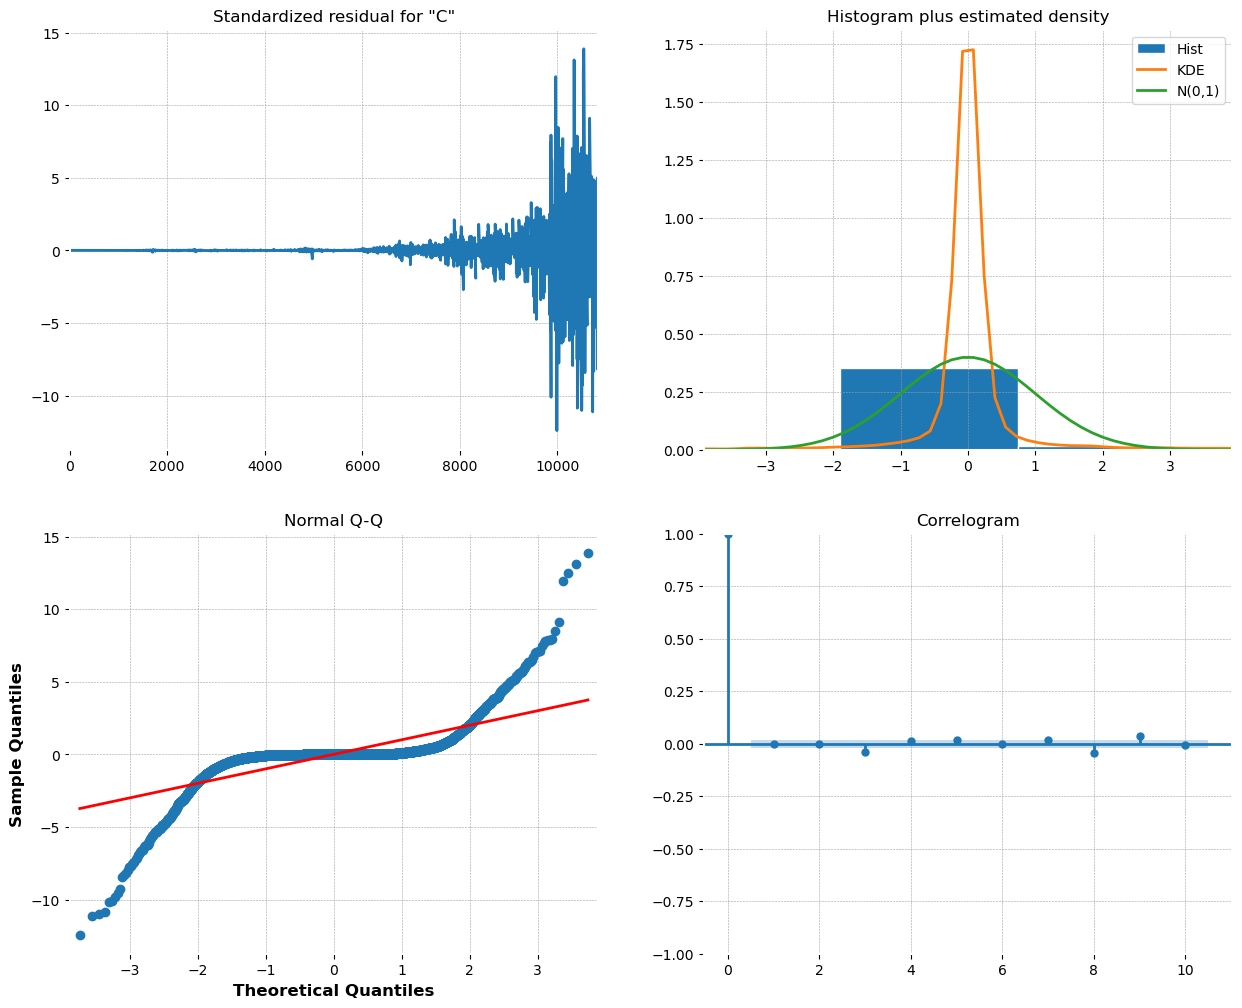

In [255]:
model_sarimax = SARIMAX(close_prices, order=best_pdq, seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results_sarimax = model_sarimax.fit()

print(results_sarimax.summary())
results_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()

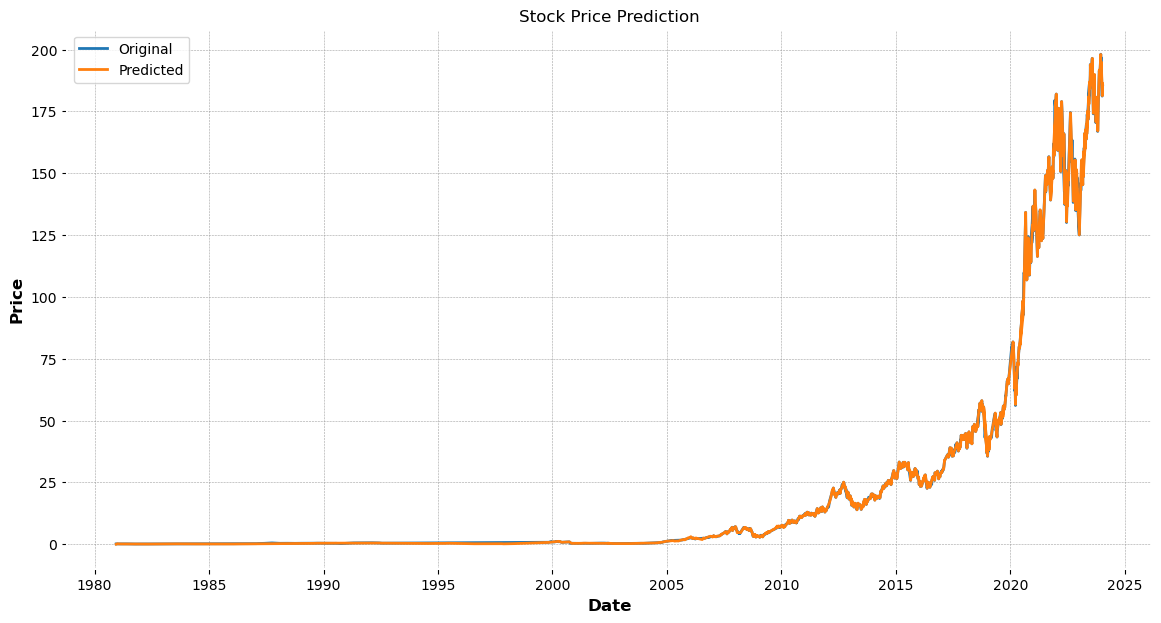

In [257]:
# Predict in-sample data and compare it with the true values
y_pred = results_sarimax.predict(start=close_prices.index[0], end=close_prices.index[-1])

plt.figure(figsize=(14, 7))
plt.plot(close_prices.index, close_prices, label='Original')
plt.plot(y_pred.index, y_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


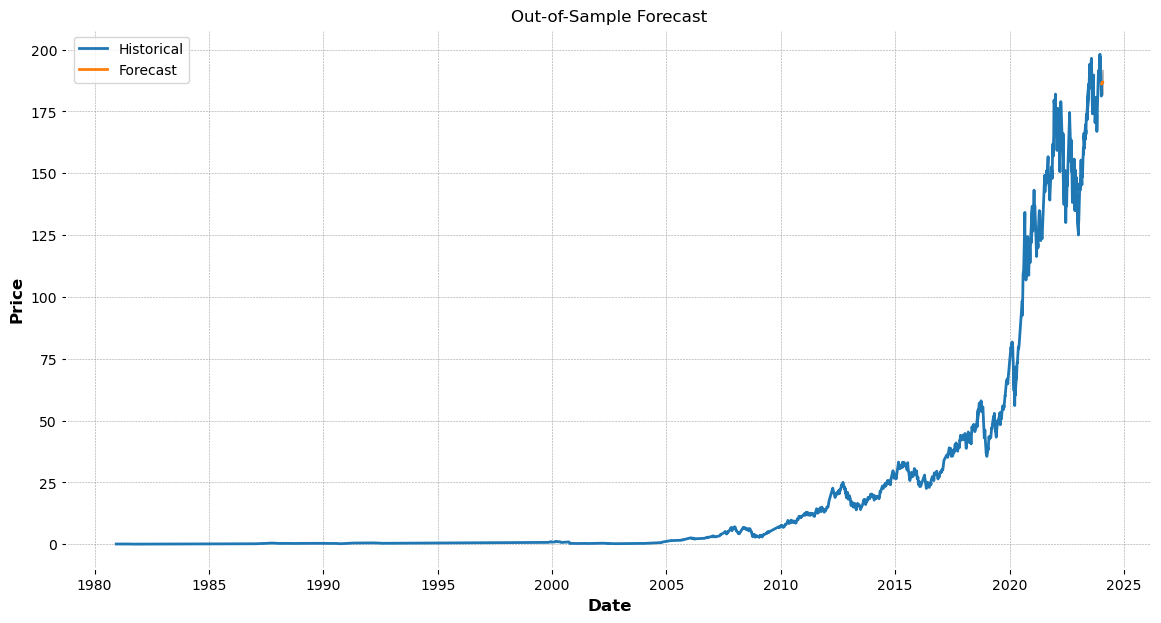

In [260]:
# Forecasting out-of-sample data
# Assume 'exog_future' is your future exogenous variables
forecast = results_sarimax.get_forecast(steps=10)
forecast_index = pd.date_range(start=close_prices.index[-1], periods=10, freq='B')  # 'B' assumes business days

# Plotting the forecast alongside the historical data
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index, close_prices, label='Historical')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='k', alpha=.25)
plt.title('Out-of-Sample Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()